# Computer Vision CSCI-GA.2272-001 Assignment 1, part 2.

Fall 2021 semester.

Due date: **September 30th 2021.**

## Introduction
This assignment requires you to participate in a Kaggle competition with the rest of the class on the The German Traffic Sign Recognition Benchmark [http://benchmark.ini.rub.de/?section=gtsrb&subsection=news]. The objective is to produce a model that gives the highest possible accuracy on the test portion of this dataset. You can register for the competition using the private link: https://www.kaggle.com/c/nyu-computer-vision-csci-ga2271-2021/overview.

Skeleton code is provided in the colab below. This contains code for training a simple default model and evaluating it on the test set. The evaluation script produces a file gtsrb_kaggle.csv that lists the IDs of the test set images, along with their predicted label. This file should be uploaded to the Kaggle webpage, which will then produce a test accuracy score. 

Your goal is to implement a new model architecture that improves upon the baseline performance. You are free to implement any approach covered in class or from research papers. This part will count for 50% of the overall grade for assignment 1. This Grading will depend on your Kaggle performance and rank, as well as novelty of the architecture.  

## Rules
You should make a copy of this Colab (File->Save a copy in Drive). Please start the assignment early and don’t be afraid to ask for help from either the TAs or myself. You are allowed to collaborate with other students in terms discussing ideas and possible solutions. However you code up the solution yourself, i.e. you must write your own code. Copying your friends code and just changing all the names of the variables is not allowed! You are not allowed to use solutions from similar assignments in courses from other institutions, or those found elsewhere on the web.
Your solutions should be submitted via the Brightspace system. This should include a brief description (in the Colab) explaining the model architectures you explored, citing any relevant papers or techniques that you used. You should also include convergence plots of training accuracy vs epoch for relevant models. 

### Important Details
• You are only allowed eight (8) submissions to the Kaggle evaluation server per day. This is to prevent over-fitting on the test dataset. So be sure to start the assignment early!

• You are NOT ALLOWED to use the test set labels during training in any way. Doing so will be regarded as cheating and penalized accordingly.

• The evaluation metric is accuracy, i.e. the fraction of test set examples where the predicted label agrees with the ground truth label.

• You should be able to achieve a test accuracy of at least 0.95. 

• *Extra important:* Please use your NYU NetID as your Kaggle username, so the TAs can figure out which user you are on the leaderboard. 


# Dataset Preparation


1.  Download `dataset.zip` from to your local machine.
2.  Unzip the file. You should see a `dataset` directory with three subfolders (`training,validation,testing`). 
3.  Go to Google Drive (on your NYU account) and make a directory `assign2_dataset` (New button --> New Folder).
4.  Upload each of the three subfolders to it (New button --> Folder upload). 
5.  Run the code block below. It will ask for permission to mount your Google Drive (NYU account) so this colab can access it. Paste the authorization code into the box as requested. 


In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/'My Drive'/assign2_dataset/

Mounted at /content/drive
/content/drive/My Drive/assign2_dataset


# Dataloader

In [ ]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import preprocessing

batch_size = 32
momentum = 0.9
lr = 0.01
epochs = 30
log_interval = 300

class MyDataset(Dataset):

    def __init__(self, X_path="X.pt", y_path="y.pt"):

        self.X = torch.load(X_path).squeeze(1)
        self.y = torch.load(y_path).squeeze(1)

    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = MyDataset(X_path="train/X.pt", y_path="train/y.pt")
val_dataset = MyDataset(X_path="validation/X.pt", y_path="validation/y.pt")

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

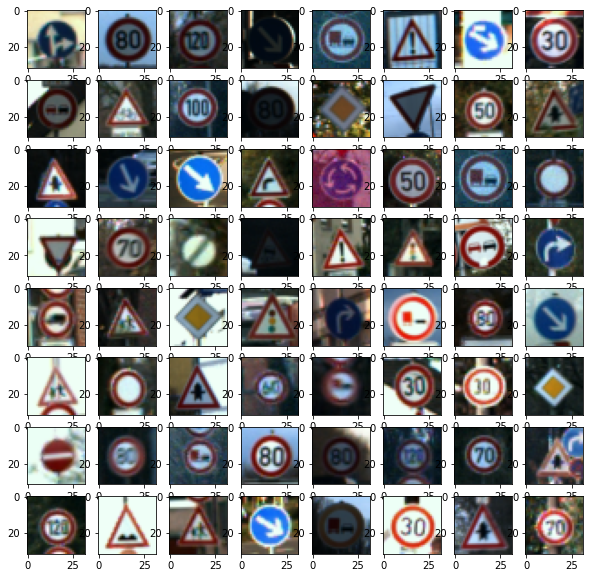

torch.Size([3, 32, 32])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Grab a sample image
i = 0
sample_number = 64
plt.figure(figsize = (10,10))

for idx in random.sample(range(1,10000), sample_number):
  i += 1
  plt.subplot(8, 8, i)
  tensor = train_dataset.__getitem__(idx)[0]
  image = np.squeeze(tensor.numpy())
  image = (image - np.min(image)) / (np.max(image) - np.min(image))
  image = image.transpose((1, 2, 0))
  plt.imshow(image)
plt.show()
print(train_dataset.__getitem__(0)[0].size())

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB as 43 classes

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 1, kernel_size=1)
        self.conv2 = nn.Conv2d(1, 29, kernel_size=5)
        self.maxpool2 = nn.MaxPool2d(3, stride=2 , ceil_mode=True)
        self.conv3 = nn.Conv2d(29, 59, kernel_size=3)
        self.maxpool3 = nn.MaxPool2d(3, stride=2 , ceil_mode=True)
        self.conv4 = nn.Conv2d(59, 74, kernel_size=3)
        self.maxpool4 = nn.MaxPool2d(3, stride=2 , ceil_mode=True)
        self.conv2_drop = nn.Dropout2d()
        self.conv3_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(1184, 300)
        self.fc2 = nn.Linear(300, nclasses)
        self.conv0_bn = nn.BatchNorm2d(3)
        self.conv1_bn = nn.BatchNorm2d(1)
        self.conv2_bn = nn.BatchNorm2d(29)
        self.conv3_bn = nn.BatchNorm2d(59)
        self.conv4_bn = nn.BatchNorm2d(74)
        self.dense1_bn = nn.BatchNorm1d(300)
    def forward(self, x):
        x =  F.relu(self.conv1_bn(self.conv1(self.conv0_bn(x))))
        
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3( self.maxpool2(x))))
        x = F.relu(self.conv4_bn(self.conv4( self.maxpool3(x))))
        #x = self.maxpool4(x) 
        x = x.view(-1, 1184)
        x = F.relu(self.fc1(x))
        x = self.dense1_bn(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.dropout(x, training=self.training)
        return F.log_softmax(x)

# Training series 1
In this training state, I used the single basic model, and explored different set of BN, scheduler, optimizer, epochs, lr, etc, and used these for my second stage of training.

## Trial 1
conv1.   3 ==> 32

conv2.   32 ==> 64

conv3.   64 ==> 128

conv4.   128 ==> 128

fc1.     512 ==> 64

fc2.     64 ==> 43


---
learning_rate decay:

using polynomial decay, 

reference: https://keras.io/api/optimizers/learning_rate_schedules/polynomial_decay/


---


Val: 97.7

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv4_drop = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(512, 64)
        #self.bn_linear = nn.BatchNorm1d(64)
        self.linear_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64, nclasses)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.bn1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.bn2(x)
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = self.bn3(x)
        x = F.relu(F.max_pool2d(self.conv4_drop(self.conv4(x)), 2))
        x = self.bn4(x)
        x = x.view(-1, 512)
        x = self.fc1(x)
        #x = self.bn_linear(x)
        x = F.relu(x)
        x = self.linear_drop(x)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
lambda1 = lambda epoch: (1 - (epoch / epochs)) ** 0.9
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))


for epoch in range(1, epochs + 1):
    train(epoch)
    validation()
    scheduler.step()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')


Train Epoch: 1 [0/35339 (0%)]	Loss: 3.770428
Train Epoch: 1 [3200/35339 (9%)]	Loss: 2.787534
Train Epoch: 1 [6400/35339 (18%)]	Loss: 2.060280
Train Epoch: 1 [9600/35339 (27%)]	Loss: 1.556535
Train Epoch: 1 [12800/35339 (36%)]	Loss: 0.882794
Train Epoch: 1 [16000/35339 (45%)]	Loss: 0.847148
Train Epoch: 1 [19200/35339 (54%)]	Loss: 0.776847
Train Epoch: 1 [22400/35339 (63%)]	Loss: 0.683006
Train Epoch: 1 [25600/35339 (72%)]	Loss: 0.280923
Train Epoch: 1 [28800/35339 (81%)]	Loss: 0.294942
Train Epoch: 1 [32000/35339 (90%)]	Loss: 0.135818
Train Epoch: 1 [35200/35339 (100%)]	Loss: 0.583614

Validation set: Average loss: 0.5711, Accuracy: 3196/3870 (83%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 0.234205
Train Epoch: 2 [3200/35339 (9%)]	Loss: 0.166798
Train Epoch: 2 [6400/35339 (18%)]	Loss: 0.061281
Train Epoch: 2 [9600/35339 (27%)]	Loss: 0.157667
Train Epoch: 2 [12800/35339 (36%)]	Loss: 0.247765
Train Epoch: 2 [16000/35339 (45%)]	Loss: 0.130946
Train Epoch: 2 [19200/

## Trial 2
expand the last layer from 128 into 256, observe slight decrease in 30 epochs


---

Val: 96.97

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv3_drop = nn.Dropout2d(0.25)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv4_drop = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(1024, 64)
        self.bn_linear = nn.BatchNorm1d(64)
        self.linear_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64, nclasses)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3_drop(self.conv3(x)))), 2)
        x = F.max_pool2d(F.relu(self.bn4(self.conv4_drop(self.conv4(x)))), 2)
        x = x.view(-1, 1024)
        x = self.fc1(x)
        x = self.bn_linear(x)
        x = F.relu(x)
        x = self.linear_drop(x)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
lambda1 = lambda epoch: (1 - (epoch / epochs)) ** 0.95
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.00f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))


for epoch in range(1, epochs + 1):
    train(epoch)
    validation()
    scheduler.step()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')


Train Epoch: 1 [0/35339 (0%)]	Loss: 4.117016
Train Epoch: 1 [16000/35339 (45%)]	Loss: 1.570727
Train Epoch: 1 [32000/35339 (90%)]	Loss: 0.858809

Validation set: Average loss: 1.0842, Accuracy: 2511/3870 (65%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 0.687735
Train Epoch: 2 [16000/35339 (45%)]	Loss: 0.395431
Train Epoch: 2 [32000/35339 (90%)]	Loss: 0.261508

Validation set: Average loss: 0.3580, Accuracy: 3424/3870 (88%)


Saved model to model_2.pth.
Train Epoch: 3 [0/35339 (0%)]	Loss: 0.397971
Train Epoch: 3 [16000/35339 (45%)]	Loss: 0.211420
Train Epoch: 3 [32000/35339 (90%)]	Loss: 0.248853

Validation set: Average loss: 0.3489, Accuracy: 3421/3870 (88%)


Saved model to model_3.pth.
Train Epoch: 4 [0/35339 (0%)]	Loss: 0.156097
Train Epoch: 4 [16000/35339 (45%)]	Loss: 0.319514
Train Epoch: 4 [32000/35339 (90%)]	Loss: 0.119145

Validation set: Average loss: 0.1760, Accuracy: 3659/3870 (95%)


Saved model to model_4.pth.
Train Epoch: 5 [0/35339 (0%)]	Loss: 0.08

## Trial 3
in this trail I changed the initial learning rate for adam, frmo 1e-3 to 1e-4. the outcome shows that the model converges too slow.


---

Val: 96.4

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv4_drop = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(512, 64)
        self.bn_linear = nn.BatchNorm1d(64)
        self.linear_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64, nclasses)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), 2)
        x = F.max_pool2d(F.relu(self.bn4(self.conv4_drop(self.conv4(x)))), 2)
        x = x.view(-1, 512)
        x = self.fc1(x)
        x = self.bn_linear(x)
        x = F.relu(x)
        x = self.linear_drop(x)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
model.load_state_dict(torch.load('9_24_27_3.pth'))
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
lambda1 = lambda epoch: (1 - (epoch / epochs)) ** 0.9
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.00f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))


for epoch in range(1, epochs + 1):
    train(epoch)
    validation()
    scheduler.step()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')


Train Epoch: 1 [0/35339 (0%)]	Loss: 13.182856
Train Epoch: 1 [16000/35339 (45%)]	Loss: 1.096315
Train Epoch: 1 [32000/35339 (90%)]	Loss: 0.321715

Validation set: Average loss: 0.3931, Accuracy: 3518/3870 (91%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 0.185372
Train Epoch: 2 [16000/35339 (45%)]	Loss: 0.048447
Train Epoch: 2 [32000/35339 (90%)]	Loss: 0.072397

Validation set: Average loss: 0.2185, Accuracy: 3658/3870 (95%)


Saved model to model_2.pth.
Train Epoch: 3 [0/35339 (0%)]	Loss: 0.070927
Train Epoch: 3 [16000/35339 (45%)]	Loss: 0.031694
Train Epoch: 3 [32000/35339 (90%)]	Loss: 0.019277

Validation set: Average loss: 0.2128, Accuracy: 3648/3870 (94%)


Saved model to model_3.pth.
Train Epoch: 4 [0/35339 (0%)]	Loss: 0.252625
Train Epoch: 4 [16000/35339 (45%)]	Loss: 0.095500
Train Epoch: 4 [32000/35339 (90%)]	Loss: 0.079021

Validation set: Average loss: 0.1631, Accuracy: 3700/3870 (96%)


Saved model to model_4.pth.
Train Epoch: 5 [0/35339 (0%)]	Loss: 0.0

## Trial 4
Base on the previous two trials, we believe the model did not receive sufficient training, so in the shceduler part, I changed the learning rate decay coefficient from 0.9 to 0.95

We also inport batch normalization in linear layer, and changed the order of conv, relu, bn, and pooling.


the accuracy is slightly better after we decrease the lr decay rate, reason may be that our model need more training epochs to improve. So in the following trials, I do extra tuning after 30 epochs for the best model.


---

Val: 97.77

---

Reference:

ankitbko (Ankit Sinha), geniusgeek (Samuel Ekpe), &amp; drscotthawley (Scott H Hawley). (2020, February 15). Order of layers in model. Deep Learning Course Forums. Retrieved September 30, 2021, from https://forums.fast.ai/t/order-of-layers-in-model/1261/3. 


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv4_drop = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(512, 64)
        self.bn_linear = nn.BatchNorm1d(64)
        self.linear_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64, nclasses)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), 2)
        x = F.max_pool2d(F.relu(self.bn4(self.conv4_drop(self.conv4(x)))), 2)
        x = x.view(-1, 512)
        x = self.fc1(x)
        x = self.bn_linear(x)
        x = F.relu(x)
        x = self.linear_drop(x)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
model.to(device)
optimizer=torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-05, amsgrad=False)
lambda1 = lambda epoch: (1 - (epoch / epochs)) ** 0.95
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))


for epoch in range(1, epochs + 1):
    train(epoch)
    validation()
    scheduler.step()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')

Train Epoch: 1 [0/35339 (0%)]	Loss: 3.956782
Train Epoch: 1 [16000/35339 (45%)]	Loss: 1.519490
Train Epoch: 1 [32000/35339 (90%)]	Loss: 0.481421

Validation set: Average loss: 1.0582, Accuracy: 2542/3870 (66%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 0.618419
Train Epoch: 2 [16000/35339 (45%)]	Loss: 0.321281
Train Epoch: 2 [32000/35339 (90%)]	Loss: 0.154665

Validation set: Average loss: 0.3672, Accuracy: 3446/3870 (89%)


Saved model to model_2.pth.
Train Epoch: 3 [0/35339 (0%)]	Loss: 0.322047
Train Epoch: 3 [16000/35339 (45%)]	Loss: 0.115330
Train Epoch: 3 [32000/35339 (90%)]	Loss: 0.094170

Validation set: Average loss: 0.2206, Accuracy: 3624/3870 (94%)


Saved model to model_3.pth.
Train Epoch: 4 [0/35339 (0%)]	Loss: 0.280096
Train Epoch: 4 [16000/35339 (45%)]	Loss: 0.318089
Train Epoch: 4 [32000/35339 (90%)]	Loss: 0.283447

Validation set: Average loss: 0.1946, Accuracy: 3647/3870 (94%)


Saved model to model_4.pth.
Train Epoch: 5 [0/35339 (0%)]	Loss: 0.07

## Trial 5
expand the fc2 layer from 64 to 128, outcome decreases. So we used the original propotion fc1/fc2 =~ 10.

# Training series 2
During this training period, I explored different structures, add attention/spatial triansformer, and fine tuning for outstanding models. The best-performenced models are used for ensembling.

## Trial_1
3 ==> 50

50==> 100

100 ==> 150

150 ==> 150


---
400 ==> 100
100 ==> 43



---

instead of base 32, I tried base 50, and using four conv layers to get 150 layers' output. However, the outcome is not ideal. so we go back to the original structure with base 32.

---

Val: 97.13


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 50, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(25)

        self.conv2 = nn.Conv2d(50, 100, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(50)

        self.conv3 = nn.Conv2d(100, 150, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(100)

        self.conv4 = nn.Conv2d(150, 150, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(100)

        self.conv4_drop = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(400, 100)
        self.bn_linear = nn.BatchNorm1d(100)
        self.linear_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(100, nclasses)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.bn1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.bn2(x)
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = self.bn3(x)
        x = F.relu(F.max_pool2d(self.conv4_drop(self.conv4(x)), 2))
        x = self.bn4(x)
        x = x.view(-1, 400)
        x = self.fc1(x)
        x = self.bn_linear(x)
        x = F.relu(x)
        x = self.linear_drop(x)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
lambda1 = lambda epoch: (1 - (epoch / epochs)) ** 0.9
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))


for epoch in range(1, epochs + 1):
    train(epoch)
    validation()
    scheduler.step()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')


Train Epoch: 1 [0/35339 (0%)]	Loss: 3.967620
Train Epoch: 1 [16000/35339 (45%)]	Loss: 1.629185
Train Epoch: 1 [32000/35339 (90%)]	Loss: 0.568184

Validation set: Average loss: 1.1335, Accuracy: 2429/3870 (63%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 0.432094
Train Epoch: 2 [16000/35339 (45%)]	Loss: 0.648469
Train Epoch: 2 [32000/35339 (90%)]	Loss: 0.323813

Validation set: Average loss: 0.4994, Accuracy: 3260/3870 (84%)


Saved model to model_2.pth.
Train Epoch: 3 [0/35339 (0%)]	Loss: 0.204763
Train Epoch: 3 [16000/35339 (45%)]	Loss: 0.349268
Train Epoch: 3 [32000/35339 (90%)]	Loss: 0.054828

Validation set: Average loss: 0.3048, Accuracy: 3522/3870 (91%)


Saved model to model_3.pth.
Train Epoch: 4 [0/35339 (0%)]	Loss: 0.150583
Train Epoch: 4 [16000/35339 (45%)]	Loss: 0.099469
Train Epoch: 4 [32000/35339 (90%)]	Loss: 0.098795

Validation set: Average loss: 0.2094, Accuracy: 3644/3870 (94%)


Saved model to model_4.pth.
Train Epoch: 5 [0/35339 (0%)]	Loss: 0.02

## Trial 2(used in ensemble)
32/64/128/128


---


512/64


---

Val: 98.32

---
We combined the best combination from training period one, and gain this score. This arrangement of conv layers yield a much better outcome than 50 base, but 512 in fc layers can be improved to extract more information from conv parts.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

class Net_trial_2(nn.Module):
    def __init__(self):
        super(Net_trial_2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv4_drop = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(512, 64)
        self.bn_linear = nn.BatchNorm1d(64)
        self.linear_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64, nclasses)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.bn1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.bn2(x)
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = self.bn3(x)
        x = self.conv4_drop(F.relu(F.max_pool2d(self.conv4(x)), 2))
        x = self.bn4(x)
        x = x.view(-1, 512)
        x = self.fc1(x)
        x = self.bn_linear(x)
        x = F.relu(x)
        x = self.linear_drop(x)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
model.to(device)
optimizer=torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
lambda1 = lambda epoch: (1 - (epoch / epochs)) ** 0.95
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

def train(epoch):
    model.train()
    num_correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        num_correct += torch.eq(output, target).sum().float().item()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
      return num_correct/len(train_loader.dataset)

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    return validation_loss


for epoch in range(1, epochs + 1):
    train(epoch)
    validation()
    scheduler.step()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')

Train Epoch: 1 [0/35339 (0%)]	Loss: 3.959068
Train Epoch: 1 [16000/35339 (45%)]	Loss: 1.162140
Train Epoch: 1 [32000/35339 (90%)]	Loss: 0.796573

Validation set: Average loss: 0.8159, Accuracy: 2944/3870 (76%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 0.418189
Train Epoch: 2 [16000/35339 (45%)]	Loss: 0.393865
Train Epoch: 2 [32000/35339 (90%)]	Loss: 0.126740

Validation set: Average loss: 0.2642, Accuracy: 3620/3870 (94%)


Saved model to model_2.pth.
Train Epoch: 3 [0/35339 (0%)]	Loss: 0.294970
Train Epoch: 3 [16000/35339 (45%)]	Loss: 0.174985
Train Epoch: 3 [32000/35339 (90%)]	Loss: 0.070130

Validation set: Average loss: 0.2447, Accuracy: 3592/3870 (93%)


Saved model to model_3.pth.
Train Epoch: 4 [0/35339 (0%)]	Loss: 0.197693
Train Epoch: 4 [16000/35339 (45%)]	Loss: 0.194348
Train Epoch: 4 [32000/35339 (90%)]	Loss: 0.033705

Validation set: Average loss: 0.1550, Accuracy: 3689/3870 (95%)


Saved model to model_4.pth.
Train Epoch: 5 [0/35339 (0%)]	Loss: 0.02

In [ ]:
import matplotlib.pyplot as plt
import numpy
history = {'accuracy':
           'val_accuracy':}
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

save model_27 to 9_24_27_3.pth
save model_30 to 9_24_30_3.pth

## Trial 2-2
remove the max pooling after the last conv layer (afraid of missing important info during pooling when few pixels are left), not good.


---
Val: 96.95


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv3_drop = nn.Dropout2d(0.5)

        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv4_drop = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(2048, 128)
        self.bn_linear = nn.BatchNorm1d(128)
        self.linear_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, nclasses)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.max_pool2d(F.relu(self.conv3_drop(self.bn3(self.conv3(x))), 2))
        x = F.relu(self.conv4_drop(self.bn4(self.conv4(x))))
        x = x.view(-1, 2048)
        x = self.fc1(x)
        x = self.bn_linear(x)
        x = F.relu(x)
        x = self.linear_drop(x)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
model.to(device)
optimizer=torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
lambda1 = lambda epoch: (1 - (epoch / epochs)) ** 0.95
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))


for epoch in range(1, epochs + 1):
    train(epoch)
    validation()
    scheduler.step()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 [0/35339 (0%)]	Loss: 3.834940
Train Epoch: 1 [12800/35339 (36%)]	Loss: 1.216857
Train Epoch: 1 [25600/35339 (72%)]	Loss: 0.374894

Validation set: Average loss: 0.4689, Accuracy: 3278/3870 (85%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 0.228418
Train Epoch: 2 [12800/35339 (36%)]	Loss: 0.146575
Train Epoch: 2 [25600/35339 (72%)]	Loss: 0.160688

Validation set: Average loss: 0.2302, Accuracy: 3624/3870 (94%)


Saved model to model_2.pth.
Train Epoch: 3 [0/35339 (0%)]	Loss: 0.110625
Train Epoch: 3 [12800/35339 (36%)]	Loss: 0.102731
Train Epoch: 3 [25600/35339 (72%)]	Loss: 0.048952

Validation set: Average loss: 0.2472, Accuracy: 3609/3870 (93%)


Saved model to model_3.pth.
Train Epoch: 4 [0/35339 (0%)]	Loss: 0.023621
Train Epoch: 4 [12800/35339 (36%)]	Loss: 0.063720
Train Epoch: 4 [25600/35339 (72%)]	Loss: 0.041591

Validation set: Average loss: 0.2227, Accuracy: 3606/3870 (93%)


Saved model to model_4.pth.
Train Epoch: 5 [0/35339 (0%)]	Loss: 0.19

## Trial_3(used in ensemble)
adding spatial transformer network, it is a small cnn with larger filters and pooling, for object detection and shape regularization. 

we create a simplified network called stn, with 2 big conv filters and 1 fc layer. Then we used the rough information for photo shift and deformation.

However, since the original network is very light, the improvement seems to be impropotional to the increased computational work.


---

Val: 98.52



---
Reference:

Jaderberg, Max, Karen Simonyan, Andrew Zisserman, and Koray Kavukcuoglu. “Spatial Transformer Networks.” Computer Vision and Pattern Recognition, June 5, 2015.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
nclasses = 43 # GTSRB has 43 classes
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers import (Activation, Dense, Dropout, Flatten,
                          Lambda, MaxPooling2D)

class Net_trial_3(nn.Module):
    def __init__(self):
        super(Net_trial_3, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv4_drop = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(512, 64)
        self.bn_linear = nn.BatchNorm1d(64)
        self.linear_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64, nclasses)

        # spatial transformer localization network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )
        # tranformation regressor for theta
        self.fc_loc = nn.Sequential(
            nn.Linear(128*4*4, 256),
            nn.ReLU(True),
            nn.Linear(256, 3 * 2)
        )
        # initializing the weights and biases with identity transformations
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], 
                                                    dtype=torch.float))
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, xs.size(1)*xs.size(2)*xs.size(3))
        # calculate the transformation parameters theta
        theta = self.fc_loc(xs)
        # resize theta
        theta = theta.view(-1, 2, 3) 
        # grid generator => transformation on parameters theta
        grid = F.affine_grid(theta, x.size())
        # grid sampling => applying the spatial transformations
        x = F.grid_sample(x, grid)
        return x


    def forward(self, x):
        x = self.stn(x)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.bn1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.bn2(x)
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = self.bn3(x)
        x = F.relu(F.max_pool2d(self.conv4_drop(self.conv4(x)), 2))
        x = self.bn4(x)
        x = x.view(-1, 512)
        x = self.fc1(x)
        x = self.bn_linear(x)
        x = F.relu(x)
        x = self.linear_drop(x)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

In [ ]:
momentum = 0.9 
epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
lambda1 = lambda epoch: (1 - (epoch / epochs)) ** 0.9
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

def train(epoch):
    model.train()
    num_correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pred = output.data.max(1, keepdim=True)[1]
        num_correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return num_correct/len(train_loader.dataset)

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    return correct / len(val_loader.dataset)

train_acc = []
val_acc = []
for epoch in range(1, epochs + 1):
    train_acc.append(train(epoch))
    val_acc.append(validation())
    scheduler.step()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


Train Epoch: 1 [0/35339 (0%)]	Loss: 3.910716
Train Epoch: 1 [12800/35339 (36%)]	Loss: 1.999629
Train Epoch: 1 [25600/35339 (72%)]	Loss: 0.603803

Validation set: Average loss: 0.7086, Accuracy: 3100/3870 (80%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 0.580399
Train Epoch: 2 [12800/35339 (36%)]	Loss: 0.671690
Train Epoch: 2 [25600/35339 (72%)]	Loss: 0.127958

Validation set: Average loss: 0.2251, Accuracy: 3601/3870 (93%)


Saved model to model_2.pth.
Train Epoch: 3 [0/35339 (0%)]	Loss: 0.075340
Train Epoch: 3 [12800/35339 (36%)]	Loss: 0.104024
Train Epoch: 3 [25600/35339 (72%)]	Loss: 0.113932

Validation set: Average loss: 0.1470, Accuracy: 3726/3870 (96%)


Saved model to model_3.pth.
Train Epoch: 4 [0/35339 (0%)]	Loss: 0.025751
Train Epoch: 4 [12800/35339 (36%)]	Loss: 0.076537
Train Epoch: 4 [25600/35339 (72%)]	Loss: 0.029769

Validation set: Average loss: 0.1468, Accuracy: 3724/3870 (96%)


Saved model to model_4.pth.
Train Epoch: 5 [0/35339 (0%)]	Loss: 0.06

## Trial 4
used 1e-4 as lr for adam, converge too slow!


---
Val: 93.6


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2, bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv4_drop = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(512, 64)
        self.bn_linear = nn.BatchNorm1d(64)
        self.linear_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64, nclasses)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.bn1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.bn2(x)
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = self.bn3(x)
        x = F.relu(F.max_pool2d(self.conv4_drop(self.conv4(x)), 2))
        x = self.bn4(x)
        x = x.view(-1, 512)
        x = self.fc1(x)
        x = self.bn_linear(x)
        x = F.relu(x)
        x = self.linear_drop(x)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)


In [ ]:
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
lambda1 = lambda epoch: (1 - (epoch / epochs)) ** 0.9
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))


for epoch in range(1, epochs + 1):
    train(epoch)
    validation()
    scheduler.step()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')

Train Epoch: 1 [0/35339 (0%)]	Loss: 3.763593
Train Epoch: 1 [12800/35339 (36%)]	Loss: 2.927443
Train Epoch: 1 [25600/35339 (72%)]	Loss: 2.629389

Validation set: Average loss: 3.0588, Accuracy: 847/3870 (22%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 2.157829
Train Epoch: 2 [12800/35339 (36%)]	Loss: 1.539769
Train Epoch: 2 [25600/35339 (72%)]	Loss: 1.446753

Validation set: Average loss: 2.4921, Accuracy: 1336/3870 (35%)


Saved model to model_2.pth.
Train Epoch: 3 [0/35339 (0%)]	Loss: 1.649540
Train Epoch: 3 [12800/35339 (36%)]	Loss: 1.356399
Train Epoch: 3 [25600/35339 (72%)]	Loss: 1.293790

Validation set: Average loss: 1.9891, Accuracy: 1950/3870 (50%)


Saved model to model_3.pth.
Train Epoch: 4 [0/35339 (0%)]	Loss: 0.699415
Train Epoch: 4 [12800/35339 (36%)]	Loss: 0.834756
Train Epoch: 4 [25600/35339 (72%)]	Loss: 0.673248

Validation set: Average loss: 1.5170, Accuracy: 2435/3870 (63%)


Saved model to model_4.pth.
Train Epoch: 5 [0/35339 (0%)]	Loss: 0.583

## Trial 5
Conv1: 3 => 64, k=5, pool to half

Conv2: 64 => 128, k=3, pool to half

Conv3: 128 => 256, k=3

Conv4: 256 => 512, k=3, pool to 2x2

FC1: 2048 => 128

FC2: 128 => 43



---
Here I changed the position and size of pooling in the 3 and 4 conv blocks. 

In the original version, there were (2\*2) max poolings after conv3 and conv4, here I dropped the max pooling after conv3, and added a (4\*4) max pooling after conv4, because after conv3 the feature maps is 8\*8, pooling too frequently may lead to fair-sized information loss. 

So I try to first applying two conv filters to further process features, and then a pooling with bigger size to cut redundant pixels. This leads to a small improvement to the original model. 

Also, the previous model got stucked when accuracy achieved 98%, the reason, I guess, is that 512 in fc layers is too small for collecting all useful information from conv layers. So I extend the first fc layer into 2048 nodes in thw next trial.

---
Val: 98.09


---

After the original training, I observed that the model failed to converge further in the second half of epochs.

I continued to tuning the best model in the previous rounds of training (30 epochs) for an extra 10 epoch, and repeat the step 2 times.

---
Final Val: 98.16

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

class Net_trial_5(nn.Module):
    def __init__(self):
        super(Net_trial_5, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        self.conv4_drop = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(2048, 128)
        self.bn_linear = nn.BatchNorm1d(128)
        self.linear_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, nclasses)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(F.relu(self.bn4(self.conv4_drop(self.conv4(x)))), 4)
        x = x.view(-1, 2048)
        x = self.fc1(x)
        x = self.bn_linear(x)
        x = F.relu(x)
        x = self.linear_drop(x)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        self.conv4_drop = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(2048, 128)
        self.bn_linear = nn.BatchNorm1d(128)
        self.linear_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, nclasses)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(F.relu(self.bn4(self.conv4_drop(self.conv4(x)))), 4)
        x = x.view(-1, 2048)
        x = self.fc1(x)
        x = self.bn_linear(x)
        x = F.relu(x)
        x = self.linear_drop(x)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 [0/35339 (0%)]	Loss: 3.802401
Train Epoch: 1 [9600/35339 (27%)]	Loss: 1.549298
Train Epoch: 1 [19200/35339 (54%)]	Loss: 0.619770
Train Epoch: 1 [28800/35339 (81%)]	Loss: 0.305335

Validation set: Average loss: 0.4188, Accuracy: 3401/3870 (88%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 0.238261
Train Epoch: 2 [9600/35339 (27%)]	Loss: 0.055105
Train Epoch: 2 [19200/35339 (54%)]	Loss: 0.094778
Train Epoch: 2 [28800/35339 (81%)]	Loss: 0.063844

Validation set: Average loss: 0.2059, Accuracy: 3641/3870 (94%)


Saved model to model_2.pth.
Train Epoch: 3 [0/35339 (0%)]	Loss: 0.074169
Train Epoch: 3 [9600/35339 (27%)]	Loss: 0.033362
Train Epoch: 3 [19200/35339 (54%)]	Loss: 0.039767
Train Epoch: 3 [28800/35339 (81%)]	Loss: 0.067346

Validation set: Average loss: 0.1499, Accuracy: 3676/3870 (95%)


Saved model to model_3.pth.
Train Epoch: 4 [0/35339 (0%)]	Loss: 0.103987
Train Epoch: 4 [9600/35339 (27%)]	Loss: 0.042253
Train Epoch: 4 [19200/35339 (54%)]	Loss

In [ ]:
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
model.load_state_dict(torch.load('model_18.pth'))
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0)
lambda1 = lambda epoch: (1 - (epoch / epochs)) ** 0.9
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
epochs = 10

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))


for epoch in range(1, epochs + 1):
    train(epoch)
    validation()
    scheduler.step()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')

Train Epoch: 1 [0/35339 (0%)]	Loss: 0.003595
Train Epoch: 1 [9600/35339 (27%)]	Loss: 0.002133
Train Epoch: 1 [19200/35339 (54%)]	Loss: 0.000186
Train Epoch: 1 [28800/35339 (81%)]	Loss: 0.000494

Validation set: Average loss: 0.0795, Accuracy: 3784/3870 (98%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 0.018950
Train Epoch: 2 [9600/35339 (27%)]	Loss: 0.000175
Train Epoch: 2 [19200/35339 (54%)]	Loss: 0.000016
Train Epoch: 2 [28800/35339 (81%)]	Loss: 0.000538

Validation set: Average loss: 0.0788, Accuracy: 3784/3870 (98%)


Saved model to model_2.pth.
Train Epoch: 3 [0/35339 (0%)]	Loss: 0.000157
Train Epoch: 3 [9600/35339 (27%)]	Loss: 0.000015
Train Epoch: 3 [19200/35339 (54%)]	Loss: 0.000040
Train Epoch: 3 [28800/35339 (81%)]	Loss: 0.000028

Validation set: Average loss: 0.0989, Accuracy: 3767/3870 (97%)


Saved model to model_3.pth.
Train Epoch: 4 [0/35339 (0%)]	Loss: 0.000077
Train Epoch: 4 [9600/35339 (27%)]	Loss: 0.000762
Train Epoch: 4 [19200/35339 (54%)]	Loss

In [ ]:
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
model.load_state_dict(torch.load('Trial_5_0.pth'))
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=0)
lambda1 = lambda epoch: (1 - (epoch / epochs)) ** 0.9
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
epochs = 10

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))


for epoch in range(1, epochs + 1):
    train(epoch)
    validation()
    scheduler.step()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')

Train Epoch: 1 [0/35339 (0%)]	Loss: 0.000147
Train Epoch: 1 [9600/35339 (27%)]	Loss: 0.000028
Train Epoch: 1 [19200/35339 (54%)]	Loss: 0.000057
Train Epoch: 1 [28800/35339 (81%)]	Loss: 0.000037

Validation set: Average loss: 0.0740, Accuracy: 3794/3870 (98%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 0.005583
Train Epoch: 2 [9600/35339 (27%)]	Loss: 0.001381
Train Epoch: 2 [19200/35339 (54%)]	Loss: 0.000003
Train Epoch: 2 [28800/35339 (81%)]	Loss: 0.000027

Validation set: Average loss: 0.0756, Accuracy: 3797/3870 (98%)


Saved model to model_2.pth.
Train Epoch: 3 [0/35339 (0%)]	Loss: 0.000154
Train Epoch: 3 [9600/35339 (27%)]	Loss: 0.000008
Train Epoch: 3 [19200/35339 (54%)]	Loss: 0.000102
Train Epoch: 3 [28800/35339 (81%)]	Loss: 0.000009

Validation set: Average loss: 0.0721, Accuracy: 3795/3870 (98%)


Saved model to model_3.pth.
Train Epoch: 4 [0/35339 (0%)]	Loss: 0.000018
Train Epoch: 4 [9600/35339 (27%)]	Loss: 0.000023
Train Epoch: 4 [19200/35339 (54%)]	Loss

## Trial 5-2
Instead of training 50 epochs and do complex lr decay, I tried to use 1e-4 for adam optimizer, the mode terined out to converge too slow.

---
Val: 97.26


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        self.conv4_drop = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(2048, 128)
        self.bn_linear = nn.BatchNorm1d(128)
        self.linear_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, nclasses)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(F.relu(self.bn4(self.conv4_drop(self.conv4(x)))), 4)
        x = x.view(-1, 2048)
        x = self.fc1(x)
        x = self.bn_linear(x)
        x = F.relu(x)
        x = self.linear_drop(x)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

In [ ]:
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0)
epochs = 30
l_rate = 1e-4

def scheduler(optimizer, epoch):
  lr = l_rate*(0.1**(epoch//30))
  for param in optimizer.param_groups:
    param['lr'] = lr

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))


for epoch in range(1, epochs + 1):
    train(epoch)
    validation()
    scheduler(optimizer, epoch)
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')

Train Epoch: 1 [0/35339 (0%)]	Loss: 3.692888
Train Epoch: 1 [9600/35339 (27%)]	Loss: 2.441201
Train Epoch: 1 [19200/35339 (54%)]	Loss: 2.282941
Train Epoch: 1 [28800/35339 (81%)]	Loss: 1.333809

Validation set: Average loss: 1.9722, Accuracy: 2075/3870 (54%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 1.037845
Train Epoch: 2 [9600/35339 (27%)]	Loss: 0.742293
Train Epoch: 2 [19200/35339 (54%)]	Loss: 0.532859
Train Epoch: 2 [28800/35339 (81%)]	Loss: 0.490029

Validation set: Average loss: 0.9251, Accuracy: 3048/3870 (79%)


Saved model to model_2.pth.
Train Epoch: 3 [0/35339 (0%)]	Loss: 0.409446
Train Epoch: 3 [9600/35339 (27%)]	Loss: 0.298757
Train Epoch: 3 [19200/35339 (54%)]	Loss: 0.238902
Train Epoch: 3 [28800/35339 (81%)]	Loss: 0.473202

Validation set: Average loss: 0.4434, Accuracy: 3485/3870 (90%)


Saved model to model_3.pth.
Train Epoch: 4 [0/35339 (0%)]	Loss: 0.164466
Train Epoch: 4 [9600/35339 (27%)]	Loss: 0.055612
Train Epoch: 4 [19200/35339 (54%)]	Loss

## Trial 5_3
use 0.51e-3 as learning rate, plus weight decay.

---
Val: 98.0


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        self.conv4_drop = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(2048, 128)
        self.bn_linear = nn.BatchNorm1d(128)
        self.linear_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, nclasses)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(F.relu(self.bn4(self.conv4_drop(self.conv4(x)))), 4)
        x = x.view(-1, 2048)
        x = self.fc1(x)
        x = self.bn_linear(x)
        x = F.relu(x)
        x = self.linear_drop(x)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

In [ ]:
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.5*1e-3, weight_decay=1e-5)
epochs = 30
lambda1 = lambda epoch: (1 - (epoch / epochs)) ** 0.9
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))


for epoch in range(1, epochs + 1):
    train(epoch)
    validation()
    scheduler.step()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 [0/35339 (0%)]	Loss: 3.914707
Train Epoch: 1 [9600/35339 (27%)]	Loss: 1.543974
Train Epoch: 1 [19200/35339 (54%)]	Loss: 0.829700
Train Epoch: 1 [28800/35339 (81%)]	Loss: 0.276085

Validation set: Average loss: 0.4752, Accuracy: 3456/3870 (89%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 0.150471
Train Epoch: 2 [9600/35339 (27%)]	Loss: 0.365885
Train Epoch: 2 [19200/35339 (54%)]	Loss: 0.069123
Train Epoch: 2 [28800/35339 (81%)]	Loss: 0.112371

Validation set: Average loss: 0.1700, Accuracy: 3717/3870 (96%)


Saved model to model_2.pth.
Train Epoch: 3 [0/35339 (0%)]	Loss: 0.085001
Train Epoch: 3 [9600/35339 (27%)]	Loss: 0.020142
Train Epoch: 3 [19200/35339 (54%)]	Loss: 0.045441
Train Epoch: 3 [28800/35339 (81%)]	Loss: 0.063878

Validation set: Average loss: 0.1467, Accuracy: 3725/3870 (96%)


Saved model to model_3.pth.
Train Epoch: 4 [0/35339 (0%)]	Loss: 0.052403
Train Epoch: 4 [9600/35339 (27%)]	Loss: 0.055604
Train Epoch: 4 [19200/35339 (54%)]	Loss

## Trial 6
Here I changed the number of filters in last conv layer from 512 to 256, which gives us size 1024 after flattening. This cut down a lot of redundant parameters, and decreases the time needed to train. also, after 30 epochs, we decrease the lr to 1e-5 and do extra 10 epochs' fine tuning.


---

Val: 98.39

In [ ]:
'''
conv4 with 256 layers instead of 512
'''
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv4_drop = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(1024, 128)
        self.bn_linear = nn.BatchNorm1d(128)
        self.linear_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, nclasses)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(F.relu(self.bn4(self.conv4_drop(self.conv4(x)))), 4)
        x = x.view(-1, 1024)
        x = self.fc1(x)
        x = self.bn_linear(x)
        x = F.relu(x)
        x = self.linear_drop(x)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

In [ ]:
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.5*1e-3, weight_decay=1e-5)
epochs = 30
lambda1 = lambda epoch: (1 - (epoch / epochs)) ** 0.9
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))


for epoch in range(1, epochs + 1):
    train(epoch)
    validation()
    scheduler.step()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')

Train Epoch: 1 [0/35339 (0%)]	Loss: 3.929532
Train Epoch: 1 [9600/35339 (27%)]	Loss: 1.925107
Train Epoch: 1 [19200/35339 (54%)]	Loss: 0.751934
Train Epoch: 1 [28800/35339 (81%)]	Loss: 0.615865

Validation set: Average loss: 0.6300, Accuracy: 3188/3870 (82%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 0.293903
Train Epoch: 2 [9600/35339 (27%)]	Loss: 0.124399
Train Epoch: 2 [19200/35339 (54%)]	Loss: 0.101960
Train Epoch: 2 [28800/35339 (81%)]	Loss: 0.061229

Validation set: Average loss: 0.2007, Accuracy: 3687/3870 (95%)


Saved model to model_2.pth.
Train Epoch: 3 [0/35339 (0%)]	Loss: 0.078292
Train Epoch: 3 [9600/35339 (27%)]	Loss: 0.083656
Train Epoch: 3 [19200/35339 (54%)]	Loss: 0.114713
Train Epoch: 3 [28800/35339 (81%)]	Loss: 0.040347

Validation set: Average loss: 0.1400, Accuracy: 3740/3870 (97%)


Saved model to model_3.pth.
Train Epoch: 4 [0/35339 (0%)]	Loss: 0.019226
Train Epoch: 4 [9600/35339 (27%)]	Loss: 0.011014
Train Epoch: 4 [19200/35339 (54%)]	Loss

In [ ]:
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
model.load_state_dict(torch.load('model_24.pth'))
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=0)
lambda1 = lambda epoch: (1 - (epoch / epochs)) ** 0.9
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
epochs = 10

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))


for epoch in range(1, epochs + 1):
    train(epoch)
    validation()
    scheduler.step()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')

Train Epoch: 1 [0/35339 (0%)]	Loss: 0.000313
Train Epoch: 1 [9600/35339 (27%)]	Loss: 0.000150
Train Epoch: 1 [19200/35339 (54%)]	Loss: 0.000394
Train Epoch: 1 [28800/35339 (81%)]	Loss: 0.010132

Validation set: Average loss: 0.0752, Accuracy: 3795/3870 (98%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 0.000008
Train Epoch: 2 [9600/35339 (27%)]	Loss: 0.002184
Train Epoch: 2 [19200/35339 (54%)]	Loss: 0.000483
Train Epoch: 2 [28800/35339 (81%)]	Loss: 0.000281

Validation set: Average loss: 0.0647, Accuracy: 3799/3870 (98%)


Saved model to model_2.pth.
Train Epoch: 3 [0/35339 (0%)]	Loss: 0.000105
Train Epoch: 3 [9600/35339 (27%)]	Loss: 0.000111
Train Epoch: 3 [19200/35339 (54%)]	Loss: 0.000070
Train Epoch: 3 [28800/35339 (81%)]	Loss: 0.000017

Validation set: Average loss: 0.0672, Accuracy: 3802/3870 (98%)


Saved model to model_3.pth.
Train Epoch: 4 [0/35339 (0%)]	Loss: 0.000064
Train Epoch: 4 [9600/35339 (27%)]	Loss: 0.000884
Train Epoch: 4 [19200/35339 (54%)]	Loss

In [ ]:
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
model.load_state_dict(torch.load('Trial_6.pth'))
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=0)
lambda1 = lambda epoch: (1 - (epoch / epochs)) ** 0.8
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
epochs = 10

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))


for epoch in range(1, epochs + 1):
    train(epoch)
    validation()
    scheduler.step()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')

Train Epoch: 1 [0/35339 (0%)]	Loss: 0.011473
Train Epoch: 1 [9600/35339 (27%)]	Loss: 0.000456
Train Epoch: 1 [19200/35339 (54%)]	Loss: 0.000509
Train Epoch: 1 [28800/35339 (81%)]	Loss: 0.000146

Validation set: Average loss: 0.0603, Accuracy: 3802/3870 (98%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 0.000415
Train Epoch: 2 [9600/35339 (27%)]	Loss: 0.000021
Train Epoch: 2 [19200/35339 (54%)]	Loss: 0.000579
Train Epoch: 2 [28800/35339 (81%)]	Loss: 0.000079

Validation set: Average loss: 0.0588, Accuracy: 3810/3870 (98%)


Saved model to model_2.pth.
Train Epoch: 3 [0/35339 (0%)]	Loss: 0.000072
Train Epoch: 3 [9600/35339 (27%)]	Loss: 0.000009
Train Epoch: 3 [19200/35339 (54%)]	Loss: 0.000203
Train Epoch: 3 [28800/35339 (81%)]	Loss: 0.000638

Validation set: Average loss: 0.0618, Accuracy: 3810/3870 (98%)


Saved model to model_3.pth.
Train Epoch: 4 [0/35339 (0%)]	Loss: 0.000244
Train Epoch: 4 [9600/35339 (27%)]	Loss: 0.000034
Train Epoch: 4 [19200/35339 (54%)]	Loss

## Trial 6_2(used in ensemble)
change learning rate to 2e-4, using leaky relu instead of relu


---



Val: 98.42

In [ ]:
'''
conv4 with 256 layers instead of 512
'''
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

class Net_trial_6(nn.Module):
    def __init__(self):
        super(Net_trial_6, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv4_drop = nn.Dropout2d(0.6)

        self.fc1 = nn.Linear(1024, 128)
        self.bn_linear = nn.BatchNorm1d(128)
        self.linear_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, nclasses)

    def forward(self, x):
        x = F.max_pool2d(F.leaky_relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.leaky_relu(self.bn2(self.conv2(x))), 2)
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(F.leaky_relu(self.bn4(self.conv4_drop(self.conv4(x)))), 4)
        x = x.view(-1, 1024)
        x = self.fc1(x)
        x = self.bn_linear(x)
        x = F.relu(x)
        x = self.linear_drop(x)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

In [ ]:
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.2*1e-3, weight_decay=1e-5)
epochs = 30
lambda1 = lambda epoch: (1 - (epoch / epochs)) ** 0.9
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)


def train(epoch):
    model.train()
    num_correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pred = output.data.max(1, keepdim=True)[1]
        num_correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return num_correct/len(train_loader.dataset)

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    return correct / len(val_loader.dataset)

train_acc = []
val_acc = []
for epoch in range(1, epochs + 1):
    train_acc.append(train(epoch))
    val_acc.append(validation())
    scheduler.step()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')

Train Epoch: 1 [0/35339 (0%)]	Loss: 3.983766
Train Epoch: 1 [9600/35339 (27%)]	Loss: 2.385756
Train Epoch: 1 [19200/35339 (54%)]	Loss: 1.634875
Train Epoch: 1 [28800/35339 (81%)]	Loss: 1.248151

Validation set: Average loss: 1.5982, Accuracy: 2437/3870 (63%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 0.911330
Train Epoch: 2 [9600/35339 (27%)]	Loss: 0.385969
Train Epoch: 2 [19200/35339 (54%)]	Loss: 0.341427
Train Epoch: 2 [28800/35339 (81%)]	Loss: 0.223726

Validation set: Average loss: 0.4939, Accuracy: 3404/3870 (88%)


Saved model to model_2.pth.
Train Epoch: 3 [0/35339 (0%)]	Loss: 0.270826
Train Epoch: 3 [9600/35339 (27%)]	Loss: 0.132837
Train Epoch: 3 [19200/35339 (54%)]	Loss: 0.094719
Train Epoch: 3 [28800/35339 (81%)]	Loss: 0.201446

Validation set: Average loss: 0.2221, Accuracy: 3663/3870 (95%)


Saved model to model_3.pth.
Train Epoch: 4 [0/35339 (0%)]	Loss: 0.046852
Train Epoch: 4 [9600/35339 (27%)]	Loss: 0.104197
Train Epoch: 4 [19200/35339 (54%)]	Loss

In [ ]:
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
model.load_state_dict(torch.load('Trial_6_2.pth'))
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=0)
lambda1 = lambda epoch: (1 - (epoch / epochs)) ** 0.9
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
epochs = 10

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))


for epoch in range(1, epochs + 1):
    train(epoch)
    validation()
    scheduler.step()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')

Train Epoch: 1 [0/35339 (0%)]	Loss: 0.006982
Train Epoch: 1 [9600/35339 (27%)]	Loss: 0.000013
Train Epoch: 1 [19200/35339 (54%)]	Loss: 0.007613
Train Epoch: 1 [28800/35339 (81%)]	Loss: 0.000203

Validation set: Average loss: 0.0645, Accuracy: 3807/3870 (98%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 0.000036
Train Epoch: 2 [9600/35339 (27%)]	Loss: 0.000064
Train Epoch: 2 [19200/35339 (54%)]	Loss: 0.000027
Train Epoch: 2 [28800/35339 (81%)]	Loss: 0.000266

Validation set: Average loss: 0.0580, Accuracy: 3810/3870 (98%)


Saved model to model_2.pth.
Train Epoch: 3 [0/35339 (0%)]	Loss: 0.000086
Train Epoch: 3 [9600/35339 (27%)]	Loss: 0.000236
Train Epoch: 3 [19200/35339 (54%)]	Loss: 0.000199
Train Epoch: 3 [28800/35339 (81%)]	Loss: 0.005002

Validation set: Average loss: 0.0637, Accuracy: 3806/3870 (98%)


Saved model to model_3.pth.
Train Epoch: 4 [0/35339 (0%)]	Loss: 0.000019
Train Epoch: 4 [9600/35339 (27%)]	Loss: 0.000074
Train Epoch: 4 [19200/35339 (54%)]	Loss

Trial 7

conv4 with 256 layers instead of 512

lr=0.5*1e-3


---

Val: 98.01

In [ ]:
'''
conv4 with 256 layers instead of 512
'''
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv4_drop = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(1024, 128)
        self.bn_linear = nn.BatchNorm1d(128)
        self.linear_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, nclasses)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(F.relu(self.bn4(self.conv4_drop(self.conv4(x)))), 4)
        x = x.view(-1, 1024)
        x = self.fc1(x)
        x = self.bn_linear(x)
        x = F.relu(x)
        x = self.linear_drop(x)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

In [ ]:
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.5*1e-3, weight_decay=1e-5)
epochs = 30
lambda1 = lambda epoch: (1 - (epoch / epochs)) ** 0.9
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))


for epoch in range(1, epochs + 1):
    train(epoch)
    validation()
    scheduler.step()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')

Train Epoch: 1 [0/35339 (0%)]	Loss: 3.932243
Train Epoch: 1 [9600/35339 (27%)]	Loss: 1.745978
Train Epoch: 1 [19200/35339 (54%)]	Loss: 0.901574
Train Epoch: 1 [28800/35339 (81%)]	Loss: 0.575505

Validation set: Average loss: 0.7094, Accuracy: 3062/3870 (79%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 0.445893
Train Epoch: 2 [9600/35339 (27%)]	Loss: 0.189820
Train Epoch: 2 [19200/35339 (54%)]	Loss: 0.087238
Train Epoch: 2 [28800/35339 (81%)]	Loss: 0.141923

Validation set: Average loss: 0.1755, Accuracy: 3701/3870 (96%)


Saved model to model_2.pth.
Train Epoch: 3 [0/35339 (0%)]	Loss: 0.210169
Train Epoch: 3 [9600/35339 (27%)]	Loss: 0.088896
Train Epoch: 3 [19200/35339 (54%)]	Loss: 0.028999
Train Epoch: 3 [28800/35339 (81%)]	Loss: 0.113005

Validation set: Average loss: 0.1391, Accuracy: 3703/3870 (96%)


Saved model to model_3.pth.
Train Epoch: 4 [0/35339 (0%)]	Loss: 0.089416
Train Epoch: 4 [9600/35339 (27%)]	Loss: 0.029590
Train Epoch: 4 [19200/35339 (54%)]	Loss

Trial 8

conv4 with 256 layers instead of 512

lr = 1e-4


---


Val: 98.29

In [ ]:
'''
conv4 with 256 layers instead of 512
'''
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv4_drop = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(1024, 128)
        self.bn_linear = nn.BatchNorm1d(128)
        self.linear_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, nclasses)

        # spatial transformer localization network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )
        # tranformation regressor for theta
        self.fc_loc = nn.Sequential(
            nn.Linear(128*4*4, 256),
            nn.ReLU(True),
            nn.Linear(256, 3 * 2)
        )
        # initializing the weights and biases with identity transformations
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], 
                                                    dtype=torch.float))
        
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, xs.size(1)*xs.size(2)*xs.size(3))
        # calculate the transformation parameters theta
        theta = self.fc_loc(xs)
        # resize theta
        theta = theta.view(-1, 2, 3) 
        # grid generator => transformation on parameters theta
        grid = F.affine_grid(theta, x.size())
        # grid sampling => applying the spatial transformations
        x = F.grid_sample(x, grid)
        return x

    def forward(self, x):
        x = self.stn(x)
        x = F.max_pool2d(F.leaky_relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.leaky_relu(self.bn2(self.conv2(x))), 2)
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(F.leaky_relu(self.bn4(self.conv4_drop(self.conv4(x)))), 4)
        x = x.view(-1, 1024)
        x = self.fc1(x)
        x = self.bn_linear(x)
        x = F.leaky_relu(x)
        x = self.linear_drop(x)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)


In [ ]:
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
epochs = 30
lambda1 = lambda epoch: (1 - (epoch / epochs)) ** 0.9
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))


for epoch in range(1, epochs + 1):
    train(epoch)
    validation()
    scheduler.step()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


Train Epoch: 1 [0/35339 (0%)]	Loss: 3.909509
Train Epoch: 1 [9600/35339 (27%)]	Loss: 2.641804
Train Epoch: 1 [19200/35339 (54%)]	Loss: 2.225781
Train Epoch: 1 [28800/35339 (81%)]	Loss: 1.161973

Validation set: Average loss: 2.1079, Accuracy: 1910/3870 (49%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 1.090694
Train Epoch: 2 [9600/35339 (27%)]	Loss: 0.946440
Train Epoch: 2 [19200/35339 (54%)]	Loss: 0.899648
Train Epoch: 2 [28800/35339 (81%)]	Loss: 0.567754

Validation set: Average loss: 1.0152, Accuracy: 2976/3870 (77%)


Saved model to model_2.pth.
Train Epoch: 3 [0/35339 (0%)]	Loss: 0.371389
Train Epoch: 3 [9600/35339 (27%)]	Loss: 0.318381
Train Epoch: 3 [19200/35339 (54%)]	Loss: 0.393602
Train Epoch: 3 [28800/35339 (81%)]	Loss: 0.553781

Validation set: Average loss: 0.4528, Accuracy: 3515/3870 (91%)


Saved model to model_3.pth.
Train Epoch: 4 [0/35339 (0%)]	Loss: 0.225466
Train Epoch: 4 [9600/35339 (27%)]	Loss: 0.129169
Train Epoch: 4 [19200/35339 (54%)]	Loss

## Trial 9(used in ensemble)

In [ ]:
'''
conv4 with 256 layers instead of 512
'''
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv4_drop = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(1024, 128)
        self.bn_linear = nn.BatchNorm1d(128)
        self.linear_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, nclasses)

        self.SE = SELayer(64)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = self.SE(x)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(F.relu(self.bn4(self.conv4_drop(self.conv4(x)))), 4)
        x = x.view(-1, 1024)
        x = self.fc1(x)
        x = self.bn_linear(x)
        x = F.relu(x)
        x = self.linear_drop(x)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

In [ ]:
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.5*1e-3, weight_decay=1e-5)
epochs = 30
lambda1 = lambda epoch: (1 - (epoch / epochs)) ** 0.9
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)


def train(epoch):
    model.train()
    num_correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pred = output.data.max(1, keepdim=True)[1]
        num_correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return num_correct/len(train_loader.dataset)

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    return correct / len(val_loader.dataset)

train_acc = []
val_acc = []
for epoch in range(1, epochs + 1):
    train_acc.append(train(epoch))
    val_acc.append(validation())
    scheduler.step()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')

Train Epoch: 1 [0/35339 (0%)]	Loss: 3.947660
Train Epoch: 1 [9600/35339 (27%)]	Loss: 1.334073
Train Epoch: 1 [19200/35339 (54%)]	Loss: 0.873962
Train Epoch: 1 [28800/35339 (81%)]	Loss: 0.267962

Validation set: Average loss: 0.5388, Accuracy: 3312/3870 (86%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 0.111103
Train Epoch: 2 [9600/35339 (27%)]	Loss: 0.131552
Train Epoch: 2 [19200/35339 (54%)]	Loss: 0.224444
Train Epoch: 2 [28800/35339 (81%)]	Loss: 0.107101

Validation set: Average loss: 0.1922, Accuracy: 3671/3870 (95%)


Saved model to model_2.pth.
Train Epoch: 3 [0/35339 (0%)]	Loss: 0.036617
Train Epoch: 3 [9600/35339 (27%)]	Loss: 0.073844
Train Epoch: 3 [19200/35339 (54%)]	Loss: 0.045742
Train Epoch: 3 [28800/35339 (81%)]	Loss: 0.127576

Validation set: Average loss: 0.1504, Accuracy: 3692/3870 (95%)


Saved model to model_3.pth.
Train Epoch: 4 [0/35339 (0%)]	Loss: 0.016505
Train Epoch: 4 [9600/35339 (27%)]	Loss: 0.015882
Train Epoch: 4 [19200/35339 (54%)]	Loss

In [ ]:
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
model.load_state_dict(torch.load('Trial_9.pth'))
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
lambda1 = lambda epoch: (1 - (epoch / epochs)) ** 0.9
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
epochs = 10

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))


for epoch in range(1, epochs + 1):
    train(epoch)
    validation()
    scheduler.step()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')

Train Epoch: 1 [0/35339 (0%)]	Loss: 0.000045
Train Epoch: 1 [9600/35339 (27%)]	Loss: 0.000390
Train Epoch: 1 [19200/35339 (54%)]	Loss: 0.000249
Train Epoch: 1 [28800/35339 (81%)]	Loss: 0.001733

Validation set: Average loss: 0.0500, Accuracy: 3814/3870 (99%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 0.000022
Train Epoch: 2 [9600/35339 (27%)]	Loss: 0.002871
Train Epoch: 2 [19200/35339 (54%)]	Loss: 0.000014
Train Epoch: 2 [28800/35339 (81%)]	Loss: 0.002664

Validation set: Average loss: 0.0515, Accuracy: 3810/3870 (98%)


Saved model to model_2.pth.
Train Epoch: 3 [0/35339 (0%)]	Loss: 0.000099
Train Epoch: 3 [9600/35339 (27%)]	Loss: 0.001377
Train Epoch: 3 [19200/35339 (54%)]	Loss: 0.000034
Train Epoch: 3 [28800/35339 (81%)]	Loss: 0.000124

Validation set: Average loss: 0.0454, Accuracy: 3816/3870 (99%)


Saved model to model_3.pth.
Train Epoch: 4 [0/35339 (0%)]	Loss: 0.001211
Train Epoch: 4 [9600/35339 (27%)]	Loss: 0.000036
Train Epoch: 4 [19200/35339 (54%)]	Loss

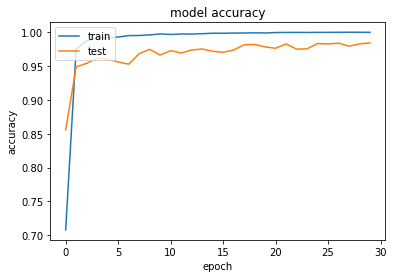

In [ ]:
import matplotlib.pyplot as plt
import numpy
history = {'accuracy':train_acc,
           'val_accuracy':val_acc}
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Trial 10

In the following trials,

 we first use 1\*1 conv to turn RGB into grey-scale image, then use previous best-performanced model to continue. 
 
 Get the inspiration from LeNet, which deals with grey-scale input.



---
Reference:(LeNet implementation)

https://d2l.ai/chapter_convolutional-neural-networks/lenet.html

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

class Net_trial_5(nn.Module):
    def __init__(self):
        super(Net_trial_5, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 60, kernel_size=5, padding=0)
        self.conv2 = nn.Conv2d(60, 60, kernel_size=5, padding=0)
        self.bn1 = nn.BatchNorm2d(60)

        self.conv1 = nn.Conv2d(60, 30, kernel_size=3, padding=0)
        self.conv2 = nn.Conv2d(30, 30, kernel_size=3, padding=0)
        self.bn1 = nn.BatchNorm2d(30)

        self.conv4_drop = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(480, 500)
        self.bn_linear = nn.BatchNorm1d(500)
        self.linear_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(500, nclasses)

    def forward(self, x):
        x = F.max_pool2d(F.leaky_relu(self.bn1(self.conv2(self.conv1(x)))), 2)
        x = F.max_pool2d(F.leaky_relu(self.bn2(self.conv4(self.conv3(x)))), 2)
        x = self.conv4_drop(x) 
        x = x.view(-1, 480)
        x = self.fc1(x)
        x = self.bn_linear(x)
        x = F.relu(x)
        x = self.linear_drop(x)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

In [ ]:
import torchvision

batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
epochs = 30
lambda1 = lambda epoch: (1 - (epoch / epochs)) ** 0.9
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)


def train(epoch):
    model.train()
    num_correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pred = output.data.max(1, keepdim=True)[1]
        num_correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return num_correct/len(train_loader.dataset)

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    return correct / len(val_loader.dataset)

train_acc = []
val_acc = []
for epoch in range(1, epochs + 1):
    train_acc.append(train(epoch))
    val_acc.append(validation())
    scheduler.step()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')

Train Epoch: 1 [0/35339 (0%)]	Loss: 3.912774
Train Epoch: 1 [9600/35339 (27%)]	Loss: 2.804682
Train Epoch: 1 [19200/35339 (54%)]	Loss: 2.032441
Train Epoch: 1 [28800/35339 (81%)]	Loss: 1.573191

Validation set: Average loss: 2.2239, Accuracy: 1721/3870 (44%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 1.448102
Train Epoch: 2 [9600/35339 (27%)]	Loss: 1.029495
Train Epoch: 2 [19200/35339 (54%)]	Loss: 0.676867
Train Epoch: 2 [28800/35339 (81%)]	Loss: 0.591976

Validation set: Average loss: 1.2017, Accuracy: 2685/3870 (69%)


Saved model to model_2.pth.
Train Epoch: 3 [0/35339 (0%)]	Loss: 0.462562
Train Epoch: 3 [9600/35339 (27%)]	Loss: 0.525086
Train Epoch: 3 [19200/35339 (54%)]	Loss: 0.490066
Train Epoch: 3 [28800/35339 (81%)]	Loss: 0.250590

Validation set: Average loss: 0.6287, Accuracy: 3317/3870 (86%)


Saved model to model_3.pth.
Train Epoch: 4 [0/35339 (0%)]	Loss: 0.304947
Train Epoch: 4 [9600/35339 (27%)]	Loss: 0.282697
Train Epoch: 4 [19200/35339 (54%)]	Loss

In [ ]:
import matplotlib.pyplot as plt
import numpy
history = {'accuracy':train_acc,
           'val_accuracy':val_acc}
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

SyntaxError: ignored

## Trial 10_2


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv0 = nn.Conv2d(3, 1, kernel_size=1, padding=0)
        self.bn0 = nn.BatchNorm2d(1)

        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv3_drop = nn.Dropout2d(0.5)

        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv4_drop = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(1024, 128)
        self.bn_linear = nn.BatchNorm1d(128)
        self.linear_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, nclasses)

        self.SE = SELayer(128)

    def forward(self, x):
        x = self.bn0(self.conv0(x))
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = self.SE(x)
        x = F.relu(self.bn3(self.conv4_drop(self.conv3(x))))
        x = F.max_pool2d(F.relu(self.bn4(self.conv4_drop(self.conv4(x)))), 4)
        x = x.view(-1, 1024)
        x = self.fc1(x)
        x = self.bn_linear(x)
        x = F.relu(x)
        x = self.linear_drop(x)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)


In [ ]:
import torchvision

batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5*1e-4, weight_decay=1e-5)
epochs = 30
lambda1 = lambda epoch: (1 - (epoch / epochs)) ** 0.9
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)


def train(epoch):
    model.train()
    num_correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pred = output.data.max(1, keepdim=True)[1]
        num_correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return num_correct/len(train_loader.dataset)

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    return correct / len(val_loader.dataset)

train_acc = []
val_acc = []
for epoch in range(1, epochs + 1):
    train_acc.append(train(epoch))
    val_acc.append(validation())
    scheduler.step()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')

Train Epoch: 1 [0/35339 (0%)]	Loss: 3.997508
Train Epoch: 1 [9600/35339 (27%)]	Loss: 1.901230
Train Epoch: 1 [19200/35339 (54%)]	Loss: 1.010125
Train Epoch: 1 [28800/35339 (81%)]	Loss: 0.254609

Validation set: Average loss: 0.6634, Accuracy: 3232/3870 (84%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 0.335574
Train Epoch: 2 [9600/35339 (27%)]	Loss: 0.113646
Train Epoch: 2 [19200/35339 (54%)]	Loss: 0.162725
Train Epoch: 2 [28800/35339 (81%)]	Loss: 0.180282

Validation set: Average loss: 0.1810, Accuracy: 3710/3870 (96%)


Saved model to model_2.pth.
Train Epoch: 3 [0/35339 (0%)]	Loss: 0.043676
Train Epoch: 3 [9600/35339 (27%)]	Loss: 0.022321
Train Epoch: 3 [19200/35339 (54%)]	Loss: 0.056001
Train Epoch: 3 [28800/35339 (81%)]	Loss: 0.041325

Validation set: Average loss: 0.1516, Accuracy: 3717/3870 (96%)


Saved model to model_3.pth.
Train Epoch: 4 [0/35339 (0%)]	Loss: 0.084110
Train Epoch: 4 [9600/35339 (27%)]	Loss: 0.033409
Train Epoch: 4 [19200/35339 (54%)]	Loss

In [ ]:
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net()
model.load_state_dict(torch.load('model_24.pth'))
model.to(device)
optimizer = torch.optim.Adadelta(model.parameters(), lr = 1e-5, weight_decay = 1e-5)
lambda1 = lambda epoch: (1 - (epoch / epochs)) ** 0.9
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)
epochs = 10

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        validation_loss += F.nll_loss(output, target, reduction="sum").item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))


for epoch in range(1, epochs + 1):
    train(epoch)
    validation()
    scheduler.step()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '.')

Train Epoch: 1 [0/35339 (0%)]	Loss: 0.000284
Train Epoch: 1 [9600/35339 (27%)]	Loss: 0.000077
Train Epoch: 1 [19200/35339 (54%)]	Loss: 0.001674
Train Epoch: 1 [28800/35339 (81%)]	Loss: 0.000050

Validation set: Average loss: 0.0978, Accuracy: 3768/3870 (97%)


Saved model to model_1.pth.
Train Epoch: 2 [0/35339 (0%)]	Loss: 0.000109
Train Epoch: 2 [9600/35339 (27%)]	Loss: 0.000036
Train Epoch: 2 [19200/35339 (54%)]	Loss: 0.000373
Train Epoch: 2 [28800/35339 (81%)]	Loss: 0.001037

Validation set: Average loss: 0.1014, Accuracy: 3763/3870 (97%)


Saved model to model_2.pth.
Train Epoch: 3 [0/35339 (0%)]	Loss: 0.000095
Train Epoch: 3 [9600/35339 (27%)]	Loss: 0.000136
Train Epoch: 3 [19200/35339 (54%)]	Loss: 0.000043
Train Epoch: 3 [28800/35339 (81%)]	Loss: 0.000142

Validation set: Average loss: 0.1118, Accuracy: 3758/3870 (97%)


Saved model to model_3.pth.
Train Epoch: 4 [0/35339 (0%)]	Loss: 0.000256
Train Epoch: 4 [9600/35339 (27%)]	Loss: 0.000998
Train Epoch: 4 [19200/35339 (54%)]	Loss

KeyboardInterrupt: ignored

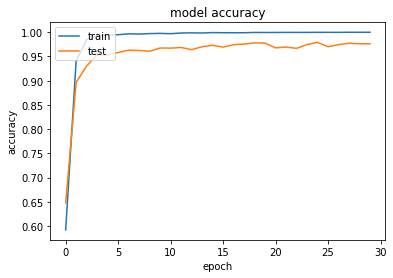

In [ ]:
import matplotlib.pyplot as plt
import numpy
history = {'accuracy':train_acc,
           'val_accuracy':val_acc}
# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Evaluate and Submit to Kaggle



## Models related: 
There is five models in the final ensemble, and each sub-block following contains: 

+ the brief introduction of model structure and explanation of techs used for training.

+ Best val accuracy

+ train/val accuracy plot 

### Model 0 structure:

This is the plain backbone of model 1 without Spatialtransformer.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

class Net_trial_2(nn.Module):
    def __init__(self):
        super(Net_trial_2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv4_drop = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(512, 64)
        self.bn_linear = nn.BatchNorm1d(64)
        self.linear_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64, nclasses)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.bn1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.bn2(x)
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = self.bn3(x)
        x = self.conv4_drop(F.relu(F.max_pool2d(self.conv4(x), 2)))
        x = self.bn4(x)
        x = x.view(-1, 512)
        x = self.fc1(x)
        x = self.bn_linear(x)
        x = F.relu(x)
        x = self.linear_drop(x)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)


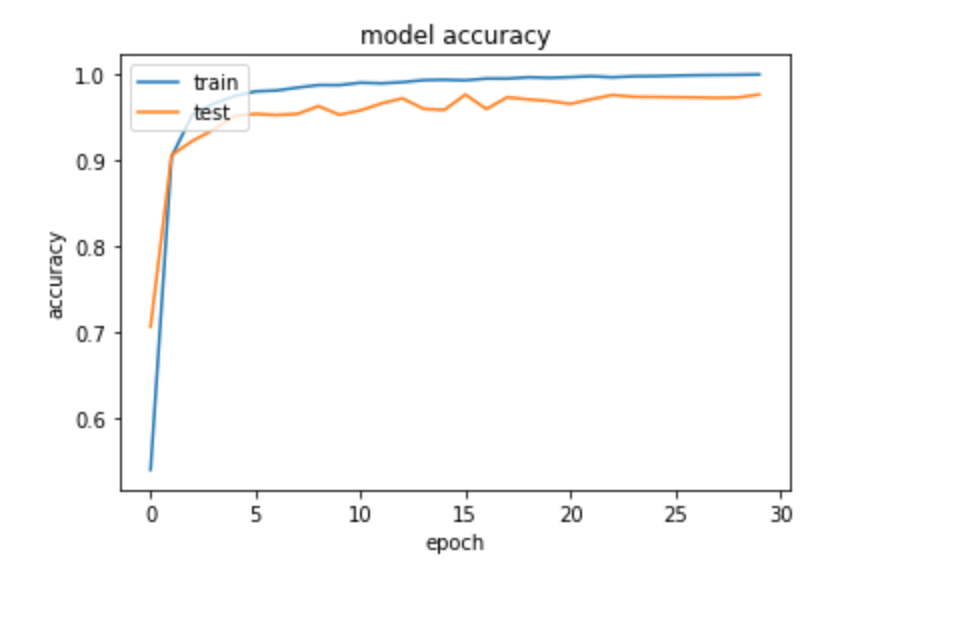

### Model 1 Structure:

    4-layer conv 

    3 -> 32 -> 64 ->128 ->128

    512 ->64 -> 43

    Spatial Transformer



---
The biggest recomposition in this model is that we added spatial transformer network. It is a small cnn with larger filters and pooling, for object detection and shape regularization. We observed some deformation of traffic sign in our dataset after visualizing them, so we introduce this structure to fix the issue.

Spatial Trasformer in this model is a simplified network called stn, with 2 big conv filters and 1 fc layer. Then we used the rough information for photo shift and deformation.

However, since the original network is very light, the improvement seems to be impropotional to the increased computational work.


---

Val: 98.52



---
Reference:

Jaderberg, Max, Karen Simonyan, Andrew Zisserman, and Koray Kavukcuoglu. “Spatial Transformer Networks.” Computer Vision and Pattern Recognition, June 5, 2015.



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
nclasses = 43 # GTSRB has 43 classes
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers import (Activation, Dense, Dropout, Flatten,
                          Lambda, MaxPooling2D)

class Net_trial_3(nn.Module):
    def __init__(self):
        super(Net_trial_3, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv4_drop = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(512, 64)
        self.bn_linear = nn.BatchNorm1d(64)
        self.linear_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64, nclasses)

        # spatial transformer localization network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )
        # tranformation regressor for theta
        self.fc_loc = nn.Sequential(
            nn.Linear(128*4*4, 256),
            nn.ReLU(True),
            nn.Linear(256, 3 * 2)
        )
        # initializing the weights and biases with identity transformations
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], 
                                                    dtype=torch.float))
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, xs.size(1)*xs.size(2)*xs.size(3))
        # calculate the transformation parameters theta
        theta = self.fc_loc(xs)
        # resize theta
        theta = theta.view(-1, 2, 3) 
        # grid generator => transformation on parameters theta
        grid = F.affine_grid(theta, x.size())
        # grid sampling => applying the spatial transformations
        x = F.grid_sample(x, grid)
        return x


    def forward(self, x):
        x = self.stn(x)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.bn1(x)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.bn2(x)
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = self.bn3(x)
        x = F.relu(F.max_pool2d(self.conv4_drop(self.conv4(x)), 2))
        x = self.bn4(x)
        x = x.view(-1, 512)
        x = self.fc1(x)
        x = self.bn_linear(x)
        x = F.relu(x)
        x = self.linear_drop(x)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

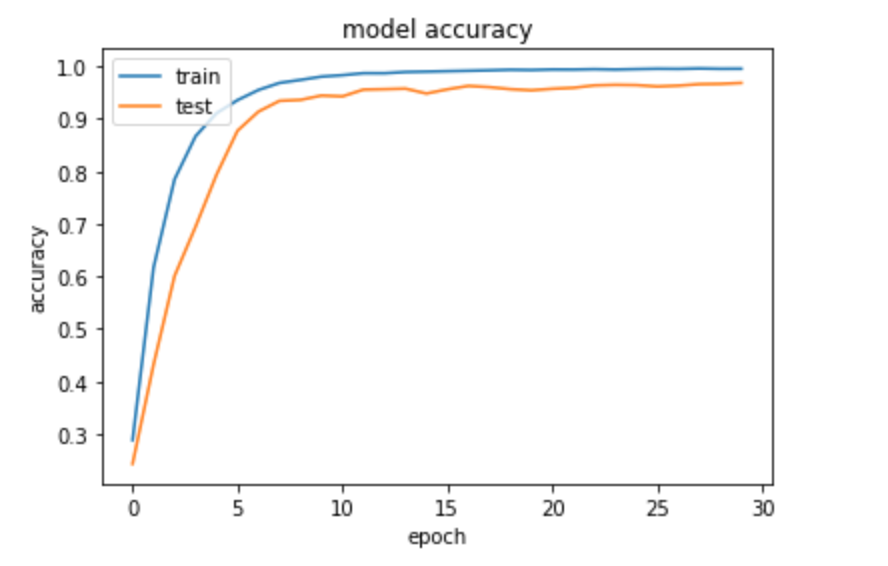

### Model 2 structure:
+ 4-layer conv 


    Conv1: 3 => 64, k=5, pool to half

    Conv2: 64 => 128, k=3, pool to half

    Conv3: 128 => 256, k=3

    Conv4: 256 => 512, k=3, pool to 2x2

    FC1: 2048 => 128

    FC2: 128 => 43



---
Here I changed the position and size of pooling in the 3 and 4 conv blocks. 

In the original version, there were (2\*2) max poolings after conv3 and conv4, here I dropped the max pooling after conv3, and added a (4\*4) max pooling after conv4, because after conv3 the feature maps is 8\*8, pooling too frequently may lead to fair-sized information loss. 

So I try to first applying two conv filters to further process features, and then a pooling with bigger size to cut redundant pixels. This leads to a small improvement to the original model. 

Also, the previous model got stucked when accuracy achieved 98%, the reason, I guess, is that 512 in fc layers is too small for collecting all useful information from conv layers. So I extend the first fc layer into 2048 nodes in thw next trial.

---
Val: 98.09


---

After the original training, I observed that the model failed to converge further in the second half of epochs.

I continued to tuning the best model in the previous rounds of training (30 epochs) for an extra 10 epoch, and repeat the step 2 times.

---
Final Val: 98.16

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

class Net_trial_5(nn.Module):
    def __init__(self):
        super(Net_trial_5, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        self.conv4_drop = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(2048, 128)
        self.bn_linear = nn.BatchNorm1d(128)
        self.linear_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, nclasses)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(F.relu(self.bn4(self.conv4_drop(self.conv4(x)))), 4)
        x = x.view(-1, 2048)
        x = self.fc1(x)
        x = self.bn_linear(x)
        x = F.relu(x)
        x = self.linear_drop(x)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

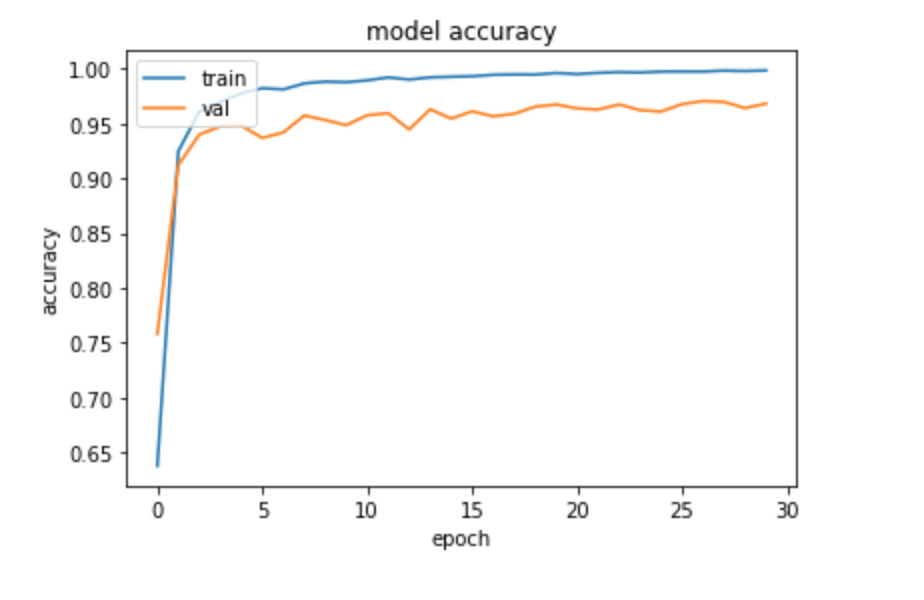

### Model 3 structure:
+ 4-layer conv 


    Conv1: 3 => 64, k=5, pool to half

    Conv2: 64 => 128, k=3, pool to half

    Conv3: 128 => 256, k=3

    Conv4: 256 => 216, k=3, pool to 2x2

    FC1: 1024 => 128

    FC2: 128 => 43


---
Here I changed the number of filters in last conv layer from 512 to 256, which gives us size 1024 after flattening. This cut down a lot of redundant parameters, and decreases the time needed to train. also, after 30 epochs, we decrease the lr to 1e-5 and do extra 10 epochs' fine tuning.


---

Val: 98.39


In [ ]:
'''
conv4 with 256 layers instead of 512
'''
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

class Net_trial_6(nn.Module):
    def __init__(self):
        super(Net_trial_6, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv4_drop = nn.Dropout2d(0.6)

        self.fc1 = nn.Linear(1024, 128)
        self.bn_linear = nn.BatchNorm1d(128)
        self.linear_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, nclasses)

    def forward(self, x):
        x = F.max_pool2d(F.leaky_relu(self.bn1(self.conv1(x))), 2)
        x = F.max_pool2d(F.leaky_relu(self.bn2(self.conv2(x))), 2)
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(F.leaky_relu(self.bn4(self.conv4_drop(self.conv4(x)))), 4)
        x = x.view(-1, 1024)
        x = self.fc1(x)
        x = self.bn_linear(x)
        x = F.relu(x)
        x = self.linear_drop(x)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

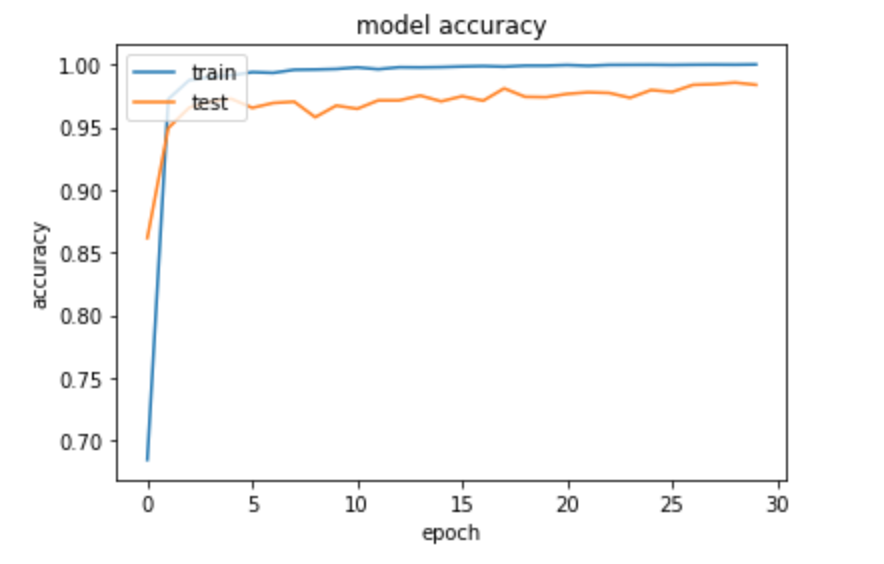

### Model 4 structure:
    4-layer conv 

    3 -> 64 ->128 ->256 -> 256

    1024 ->64 -> 43

    SE attention Module


---


The biggest twist here is we introduced SE attention block after first conv Block (among different insertion places, after first conv block yields the best result). 

One of the main features of SE Block is that it improves the relationship between feature channels, and the squeeze operation makes the feature map improve the global receptive field.


---
Reference: (SE attention module)

Hu, Jie, Li Shen, and Gang Sun. “Squeeze-and-Excitation Networks.” 2018 IEEE/CVF Conference on Computer Vision and Pattern Recognition, 2018. https://doi.org/10.1109/cvpr.2018.00745. 


In [ ]:
'''
conv4 with 256 layers instead of 512
'''
import torch
import torch.nn as nn
import torch.nn.functional as F

nclasses = 43 # GTSRB has 43 classes

class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class Net_trial_9(nn.Module):
    def __init__(self):
        super(Net_trial_9, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv4_drop = nn.Dropout2d(0.5)

        self.fc1 = nn.Linear(1024, 128)
        self.bn_linear = nn.BatchNorm1d(128)
        self.linear_drop = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, nclasses)

        self.SE = SELayer(64)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), 2)
        x = self.SE(x)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(F.relu(self.bn4(self.conv4_drop(self.conv4(x)))), 4)
        x = x.view(-1, 1024)
        x = self.fc1(x)
        x = self.bn_linear(x)
        x = F.relu(x)
        x = self.linear_drop(x)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

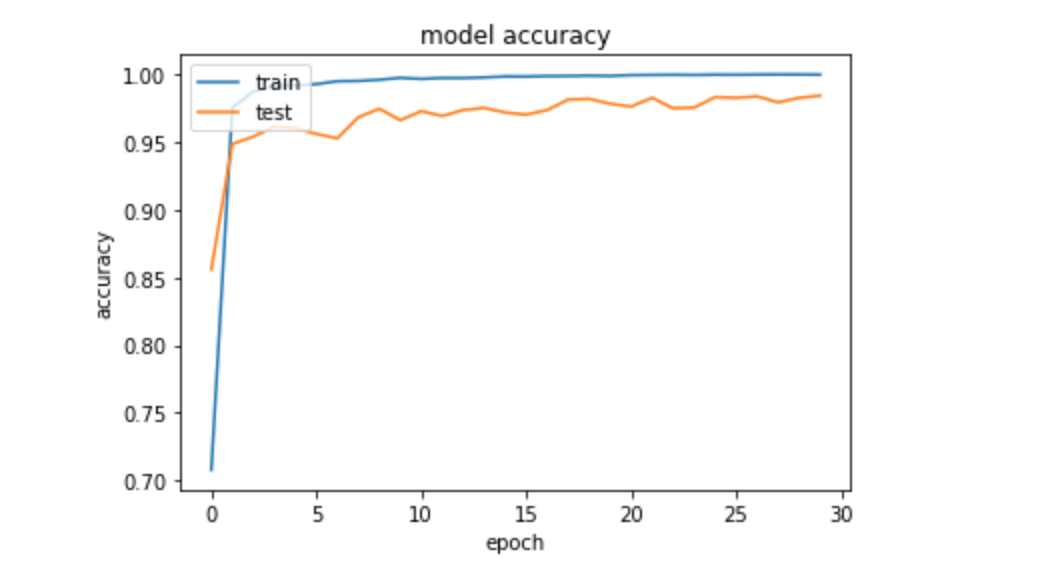

### Predicting:
we use ensembling for final prediction, which gives us the test accuracy 99.097%.

model selection:


In [ ]:
class MyDataset(Dataset):

    def __init__(self, X_path="testing/test.pt"):

        self.X = torch.load(X_path).squeeze(1)

    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx]

In [ ]:
import pickle
import pandas as pd

outfile = 'gtsrb_kaggle.csv'
output_file = open(outfile, "w")

dataframe_dict = {"Filename" : [], "ClassId": []}
file_ids = pickle.load(open('testing/file_ids.pkl', 'rb'))

test_dataset = MyDataset()
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

# settings
model_list = ['Trial_5_1.pth', 'Trial_3.pth', 'Trial_2.pth', 'Trial_6_3.pth', 'Trial_9_2.pth']

Net_1 = Net_trial_5()
Net_2 = Net_trial_3()
Net_3 = Net_trial_2()
Net_4 = Net_trial_6()
Net_5 = Net_trial_9()
model_structure = [Net_1, Net_2, Net_3, Net_4, Net_5]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pred_dict = {}

# here we use models to first create prediction (vector after softmax), 
# then select the maximim (most confidence) prediction.
for i in range(len(model_list)):
  model = model_structure[i]
  model.load_state_dict(torch.load(model_list[i]))
  model.to(device)
  model.eval()

  for batch_idx, data in enumerate(test_loader):
      data = data.to(device)
      output = model_2.pth(data))
      logi, label = output.data.max(1, keepdim=True)
      idx_base = batch_idx * 32

      for idx in range(32):
          number = idx_base + idx
          if number < len(file_ids):
              file_id = file_ids[number][0:5]
              if file_id not in pred_dict:
                  pred_dict[file_id] = []
              pred_dict[file_id] += [(logi[idx].item(), label[idx].item())]

for idx in range(len(file_ids)):
    file_id = file_ids[idx][0:5]
    best_pred = max(pred_dict[file_id], key=lambda l: l[0])
    dataframe_dict['Filename'].append(file_id)
    dataframe_dict['ClassId'].append(best_pred[1])

df = pd.DataFrame(data=dataframe_dict)
df.to_csv(outfile, index=False)
print("Written to csv file {}".format(outfile))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


Written to csv file gtsrb_kaggle.csv


# Submitting to Kaggle

Now take this csv file, download it from your Google drive and then submit it to Kaggle to check performance of your model.